In [1]:
import os
import ast
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture
from dotenv import load_dotenv, find_dotenv
from typing import Optional

# ¿Cómo funciona O-Llama y Groq?

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings(
)

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100
)

# Eliminar la primera página o portada del doc.

In [3]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

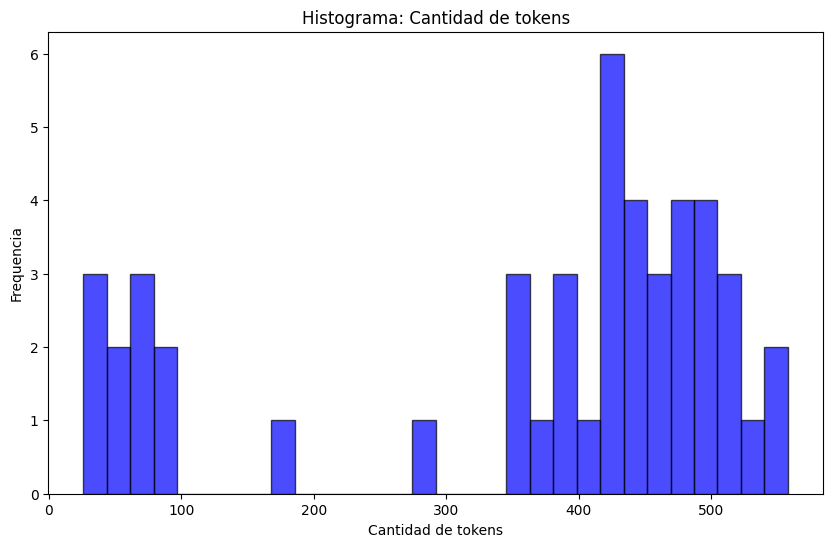

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.show()

In [5]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 16943


# 1. ¿Incrustar de cero?
# 2. ¿Elegir un encrustamiento guardado?

In [6]:
user_input = input("Elige 1 o 2: ")

if user_input.lower() == "1":
    print('Elegiste 1')
    global_embeddings = [embeddings.embed_query(txt) for txt in texts]

    embed_name = input('¿Cómo se llama esta incrustación?: ') + '_emb' + '.txt'
    with open(rf'./embed/{embed_name}', 'w') as f:
        for i in global_embeddings:
            f.write("%s\n" % i)
    
elif user_input.lower() == "2":
    print('Elegiste 2')
    global_embeddings = []

    embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

    with open(rf'./embed/{embed_name}', 'r') as f:
        for i in f:
            x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de números
            global_embeddings.append(x)

    global_embeddings = np.array(global_embeddings, dtype=float)
    
elif user_input != "1" and user_input != "2":
    print("No seleccionaste ningún encrustamiento.")

Elegiste 1


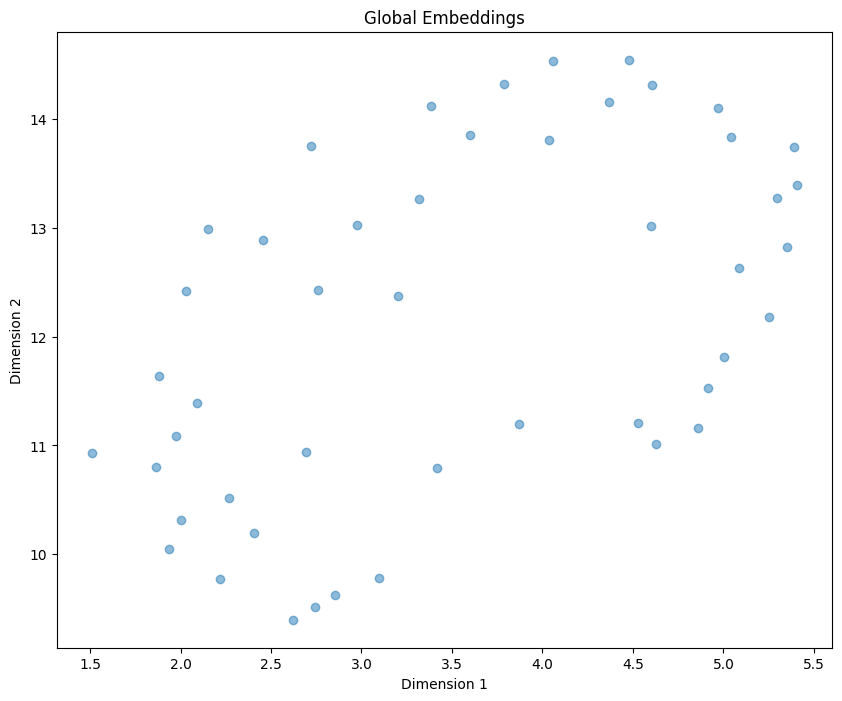

In [7]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


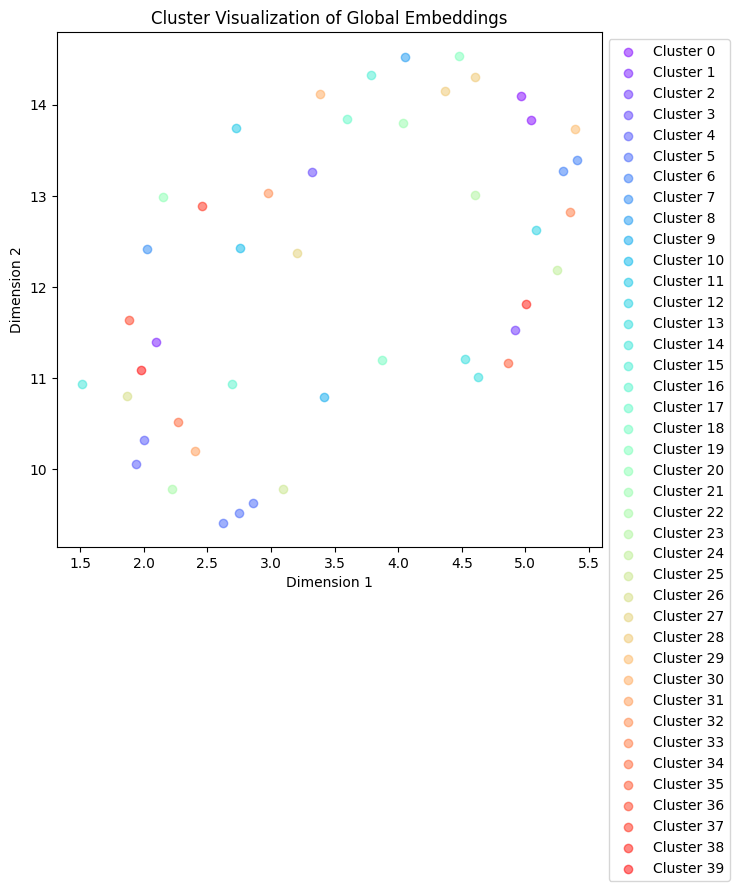

In [8]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.75, 1])

In [9]:
simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
# print(df.head(3))
df.head()

,Texto,Embedding,Cluster
0,"See discussions, st ats, and author pr ofiles ...","[1.8655599, 10.80217]",26
1,73 Estrategias para fortalecer las capacidades...,"[1.5123113, 10.927226]",14
2,INNOV ACIÓN ORGANIZACIONAL: Experiencias y ref...,"[4.528963, 11.20564]",13
3,75 Estrategias para fortalecer las capacidades...,"[2.2692504, 10.518252]",34
4,ellas que cogeneran energía eléctrica a partir...,"[2.618856, 9.399587]",5


In [10]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{26: 'See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/364350695 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca Chapt er · Dec ember 2021 CITATIONS 0READS 26 2 author s, including: Isabel Cristina Quint ero Univ ersidad P ontificia Boliv ariana 32 PUBLICA TIONS \xa0\xa0\xa031 CITATIONS \xa0\xa0\xa0 SEE PROFILE All c ontent f ollo wing this p age was uplo aded b y Isabel Cristina Quint ero on 18 Oct ober 2022. The user has r equest ed enhanc ement of the do wnlo aded file.',
 14: '73 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca ESTRATEGIAS PARA FORTALECER LAS  CAPACIDADES DE INNOV ACIÓN EN EMPRESAS DEL  CLÚSTER DE LA CAÑA EN EL V ALLE DEL CAUCA Edwin Fernando Montoya3 Isabel Cristina Quintero Sepúlveda4 Resumen La innovación está asociada a las dinámicas económicas y sociales, por lo

In [11]:
template = """Eres un revisor bibliográfico profesional encargado de crear resúmenes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [13]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

embedded_summaries = [embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [14]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

clustered_summaries

{0: ['El capítulo "Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca" aborda la importancia de implementar estrategias que impulsen la innovación en las empresas pertenecientes al clúster de la caña en esta región de Colombia. El texto fue publicado en diciembre de 2021 y cuenta con 0 citas y 262 lecturas.\n\nLa autora principal de este capítulo es Isabel Cristina Quintero, quien es investigadora en la Universidad Pontificia Bolivariana y cuenta con 32 publicaciones y 31 citas en su perfil de ResearchGate. El contenido del capítulo se centra en analizar cómo fortalecer las capacidades de innovación en las empresas del clúster de la caña, con el objetivo de mejorar su competitividad y sostenibilidad en el mercado.\n\nPara acceder al texto completo y conocer más detalles sobre las estrategias propuestas por la autora, se puede visitar el enlace proporcionado: https://www.researchgate.net/publication/364350695.',
  'El texto

In [15]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{0: 'En el capítulo "Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca", la autora principal Isabel Cristina Quintero aborda la importancia de implementar estrategias que impulsen la innovación en las empresas pertenecientes al clúster de la caña en esta región de Colombia. El texto, publicado en diciembre de 2021, destaca la importancia de la innovación en las empresas del clúster de la caña de azúcar en el Valle del Cauca, y cómo esta va más allá de la invención, centrándose en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano.\n\nLa autora, investigadora en la Universidad Pontificia Bolivariana, analiza cómo fortalecer las capacidades de innovación en las empresas del clúster de la caña, con el objetivo de mejorar su competitividad y sostenibilidad en el mercado. Se presentan tres casos empresariales en el clúster 

In [16]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [17]:
combined_texts[:10]

['See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/364350695 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca Chapt er · Dec ember 2021 CITATIONS 0READS 26 2 author s, including: Isabel Cristina Quint ero Univ ersidad P ontificia Boliv ariana 32 PUBLICA TIONS \xa0\xa0\xa031 CITATIONS \xa0\xa0\xa0 SEE PROFILE All c ontent f ollo wing this p age was uplo aded b y Isabel Cristina Quint ero on 18 Oct ober 2022. The user has r equest ed enhanc ement of the do wnlo aded file.',
 '73 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca ESTRATEGIAS PARA FORTALECER LAS  CAPACIDADES DE INNOV ACIÓN EN EMPRESAS DEL  CLÚSTER DE LA CAÑA EN EL V ALLE DEL CAUCA Edwin Fernando Montoya3 Isabel Cristina Quintero Sepúlveda4 Resumen La innovación está asociada a las dinámicas económicas y sociales, por lo que tra

In [18]:
# Nombre del archivo de texto
file_name = input('Nombre del archivo: ') + '.txt'

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [19]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [20]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

25


In [21]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas específicas. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [22]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [23]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Quiénes son los autores del artículo?
Los autores del artículo son Edwin Fernando Montoya e Isabel Cristina
Quintero Sepúlveda.

Referencias:
page_content='La autora, investigadora en la Universidad Pontificia Bolivariana, analiza cómo fortalecer las capacidades de innovación en las empresas del clúster de la caña, con el objetivo de mejorar su competitividad y sostenibilidad en el mercado. Se presentan tres casos empresariales en el clúster de la caña de azúcar en el Valle del Cauca, donde se analizan las capacidades de innovación y se proponen acciones estratégicas para mejorar dichas capacidades y los resultados de innovación de las empresas.\n\nSe destaca la importancia de desarrollar un marco de acciones estratégicas que permitan a las empresas fortalecer sus capacidades de innovación y así contribuir al desarrollo económico y social de la región. El texto aborda el tema de la innovación organizacional, resaltando la importancia de la innovación en las empresas para generar impac

In [24]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿A qué institución pertenecen los autores del artículo?
Los autores del artículo pertenecen a la Universidad Pontificia
Bolivariana.

Referencias:
page_content='La autora, investigadora en la Universidad Pontificia Bolivariana, analiza cómo fortalecer las capacidades de innovación en las empresas del clúster de la caña, con el objetivo de mejorar su competitividad y sostenibilidad en el mercado. Se presentan tres casos empresariales en el clúster de la caña de azúcar en el Valle del Cauca, donde se analizan las capacidades de innovación y se proponen acciones estratégicas para mejorar dichas capacidades y los resultados de innovación de las empresas.\n\nSe destaca la importancia de desarrollar un marco de acciones estratégicas que permitan a las empresas fortalecer sus capacidades de innovación y así contribuir al desarrollo económico y social de la región. El texto aborda el tema de la innovación organizacional, resaltando la importancia de la innovación en las empresas para generar i

In [25]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es la fecha en la que escribieron el artículo?
El artículo fue escrito en diciembre de 2021. La fecha específica de
redacción no se menciona en el contexto proporcionado, por lo que no
puedo proporcionar una respuesta exacta.

Referencias:
page_content='En el capítulo "Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca", la autora principal Isabel Cristina Quintero aborda la importancia de implementar estrategias que impulsen la innovación en las empresas pertenecientes al clúster de la caña en esta región de Colombia. El texto, publicado en diciembre de 2021, destaca la importancia de la innovación en las empresas del clúster de la caña de azúcar en el Valle del Cauca, y cómo esta va más allá de la invención, centrándose en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano.'
page_content='La autora, investigador

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

# Hacer historial y guardar conversaciones para medir efectividad.

In [ ]:
# Para archivos grandes debes dividir el texto

# # Diccionario inicial
# data = {
#     2: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN. El propósito de la investigación es analizar'
# }

# # Obtener el texto original
# original_text = data[2]

# # Encontrar el punto medio
# mid_point = len(original_text) // 2

# # Definir el tamaño del solapamiento
# overlap_size = 50

# # Calcular los puntos de división con solapamiento
# start_overlap = max(mid_point - overlap_size // 2, 0)
# end_overlap = min(mid_point + overlap_size // 2, len(original_text))

# # Dividir el texto en dos partes con solapamiento
# first_half = original_text[:end_overlap]
# second_half = original_text[start_overlap:]

# # Crear nuevas llaves en el diccionario
# data[2] = first_half
# data[3] = second_half

# # Imprimir el diccionario actualizado
# print(data)